In [ ]:
import numpy as np
import torch
from torch import nn

# Práctica 5: Tech evolution. Caso POS Tagging

**Fecha de entrega: 13 de Abril 2025**

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

**Corpus**

In [ ]:
URL = "https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/refs/heads/master/es_ancora-ud-train.conllu"


In [ ]:
import requests
from rich import print as rprint

raw_data = requests.get(URL).text

In [ ]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [ ]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [ ]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [ ]:
t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [ ]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [ ]:
conll_dict = CoNLLDictorizer()


In [ ]:

conll_dict = CoNLLDictorizer()
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [ ]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

**Preprocesamiento**

In [ ]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [ ]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [ ]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [ ]:
def extract_features(sentence: list[str], context: int=2) -> list:
    """Extraer las features de cada oración

    Para tener siempre la misma cantidad de features
    por oración aplica un ventaneo llenando los espacios
    restantes con "<BOS>" y "<EOS>"

    Parameters
    ----------
    sentence: list[str]
        Oracion en formato CoNLL
    context: int
        Cantidad de palabras a la izquierda y derecha de la palabra actual. Default: 2

    Return
    ------
    list
        Lista de diccionarios con las features de cada palabra
    """
    start_pad = ["<BOS>"] * context
    end_pad = ["<EOS>"] * context
    sentence = start_pad + sentence + end_pad
    features = []
    for i in range(len(sentence) - 2 * context):
        aux = []
        for j in range(2 * context + 1):
            aux += [sentence[i + j]]
        features += [aux]
    features = [dict(enumerate(feature)) for feature in features]
    return features

In [ ]:
def extract_corpus_features(words_set: list[list[str]], pos_tags_set: list[list[str]]):
    """Extraer las features del corpus

    Parameters
    ----------
    words_set: list[list[str]]
        Lista de listas con las palabras de cada oración
    pos_tags_set: list[list[str]]
        Lista de listas con las etiquetas POS de cada oración

    Return
    ------
    tuple
        Tupla con las features y las etiquetas POS
    """
    X_features = [row for sent in words_set for row in extract_features(sent)]
    y_features = [pos for sent in pos_tags_set for pos in sent]
    return X_features, y_features

In [ ]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
X_val_features, y_val_features = extract_corpus_features(val_sent_words, val_sent_pos)
X_test_features, y_test_features = extract_corpus_features(test_sent_words, test_sent_pos)

In [ ]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

**Embeddings**

In [ ]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 425.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0

In [ ]:
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5  # Versión estable conocida

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 89.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
bigframes 2.5.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
jax 0.5.

In [ ]:
vectors = gensim_api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [ ]:
embeddings = get_embeddings(vectors)

**Indices**

In [ ]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [ ]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [ ]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [ ]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes

In [ ]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [ ]:
for sent in t:
    for word in sent:
        print(idx2word[int(word)])

aesthetic
appreciation
and
spanish
art
:
insights
from
eye
-
tracking


In [ ]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [ ]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [ ]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

**Padding**

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[113219, 276786, 157292, 379267, 300140, 264875, 362826, 134276, 349975,
         339888,  99531, 233735, 142869, 130332,  16215, 123061,  91384, 128580,
         249211, 161366, 232265,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [227027, 349975, 339888,  41478, 393379, 227531,  24426, 150033, 117054,
         157292, 295840, 323067, 157292, 130332,  14305, 307270, 302090, 349975,
          17868, 323582, 189370, 359271,  71800,  58985, 157292, 124622, 157292,
         123061, 109701, 359608,  86625,  78976, 232265]])

In [ ]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

#### Embeddings para RNN

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [ ]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

**La Recurrent Neural Net con pytorch**

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange, tqdm

In [ ]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"Working on device={device}")

Working on device=cpu

In [ ]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

**Training loop**

In [ ]:
EPOCHS = 20

In [ ]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [ ]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODELS_PATH ="/content/drive/MyDrive/pos_taggers/rnn"


In [ ]:
import os

print(os.path.exists(MODELS_PATH))  # Debería devolver True si la ruta es válida


True


In [ ]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}


for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


## Obtenemos 100 embeddings al azar

In [ ]:


# Seleccionamos 100 palabras al azar del vocabulario
random.seed(42)
word_list = list(vocabulary)
sample_words = random.sample(word_list, 100)

static_embeddings = {word: embedding_table[word2idx[word]] for word in sample_words}



## Reduccion de dimensionalidad

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Lista de palabras seleccionadas
selected_terms = list(static_embeddings.keys())

# Convertimos a matriz NumPy
vectors = np.stack([static_embeddings[w].detach().cpu().numpy() for w in selected_terms])

# Reducción inicial con PCA (opcional pero recomendable antes de t-SNE)
pca = PCA(n_components=30, random_state=0)
vectors_reduced = pca.fit_transform(vectors)

# Proyección a 2D con t-SNE
tsne_model = TSNE(n_components=2, random_state=0, perplexity=8, init='random', learning_rate='auto')
projected_points = tsne_model.fit_transform(vectors_reduced)


In [ ]:
from sklearn.cluster import KMeans

# Número de grupos/clusters a formar
num_grupos = 4

# Modelo de agrupamiento KMeans
agrupador = KMeans(n_clusters=num_grupos, n_init=10, random_state=0)

# Etiquetas de cluster para cada vector
etiquetas_cluster = agrupador.fit(vectors_reduced).predict(vectors_reduced)


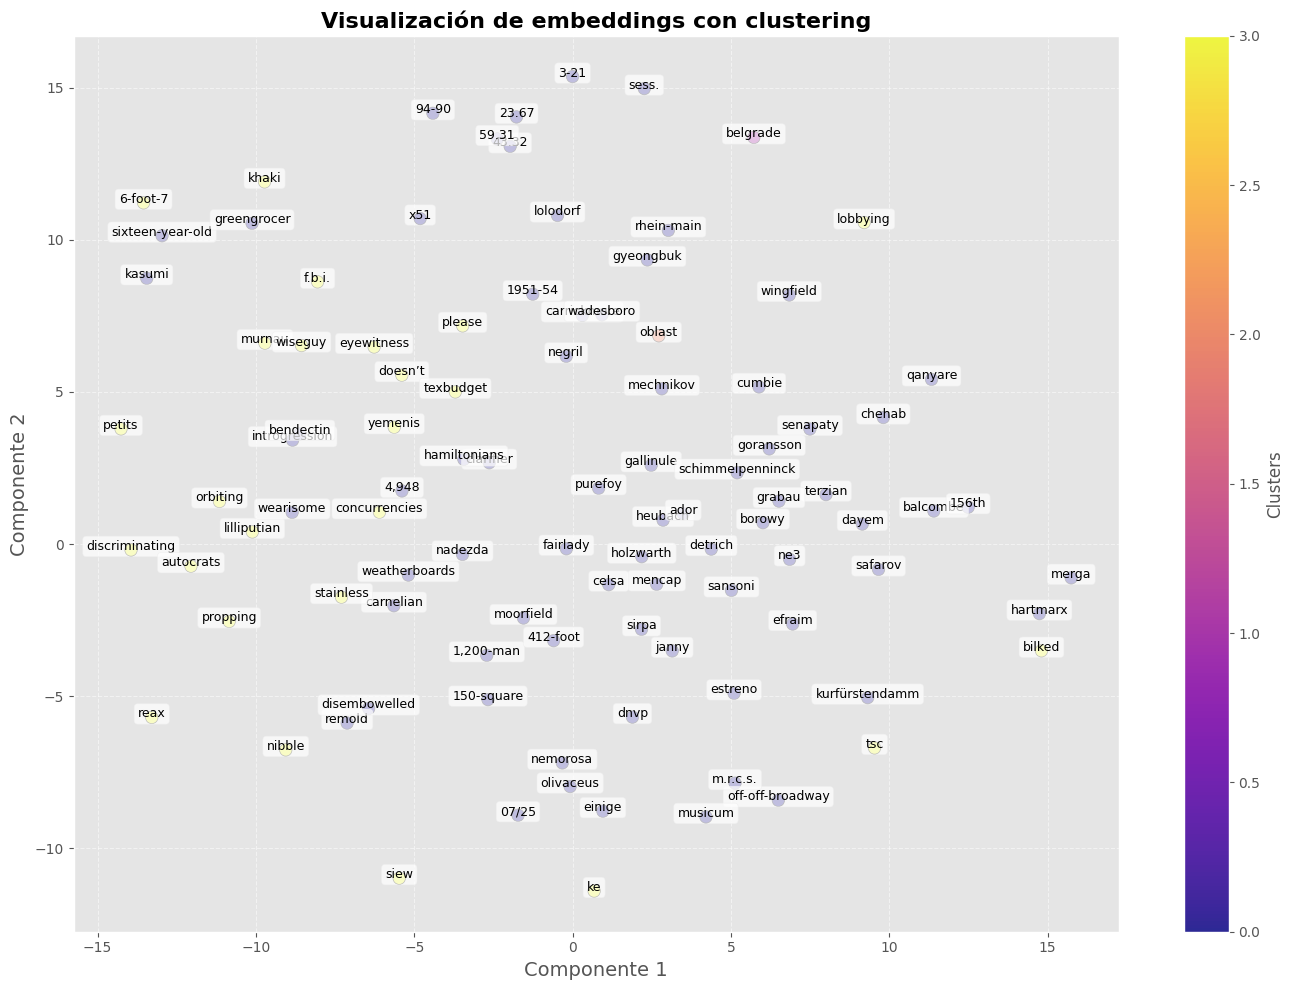

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Estilo disponible por defecto en Matplotlib

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    projected_points[:, 0], projected_points[:, 1],
    c=etiquetas_cluster, cmap='plasma',
    edgecolor='k', s=80, alpha=0.85
)

for i, word in enumerate(selected_terms):
    plt.annotate(
        word,
        (projected_points[i, 0], projected_points[i, 1]),
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
        ha='center'
    )

cbar = plt.colorbar(scatter)
cbar.set_label('Clusters')

plt.title("Visualización de embeddings con clustering", fontsize=16, weight='bold')
plt.xlabel('Componente 1', fontsize=14)
plt.ylabel('Componente 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Obtener embeddings de las etiquetas POS del modelo RNN

In [ ]:
def get_pos_embeddings(model):
    """Extrae los embeddings POS de la capa lineal final"""
    return model.linear.weight.detach().cpu().numpy()

In [ ]:
pos_embeddings_array = get_pos_embeddings(rnn_model)
pos_tags = list(pos2idx.keys())

In [ ]:
print(len(pos_embeddings_array))
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
pos_embeddings_2d = tsne.fit_transform(pos_embeddings_array)

20


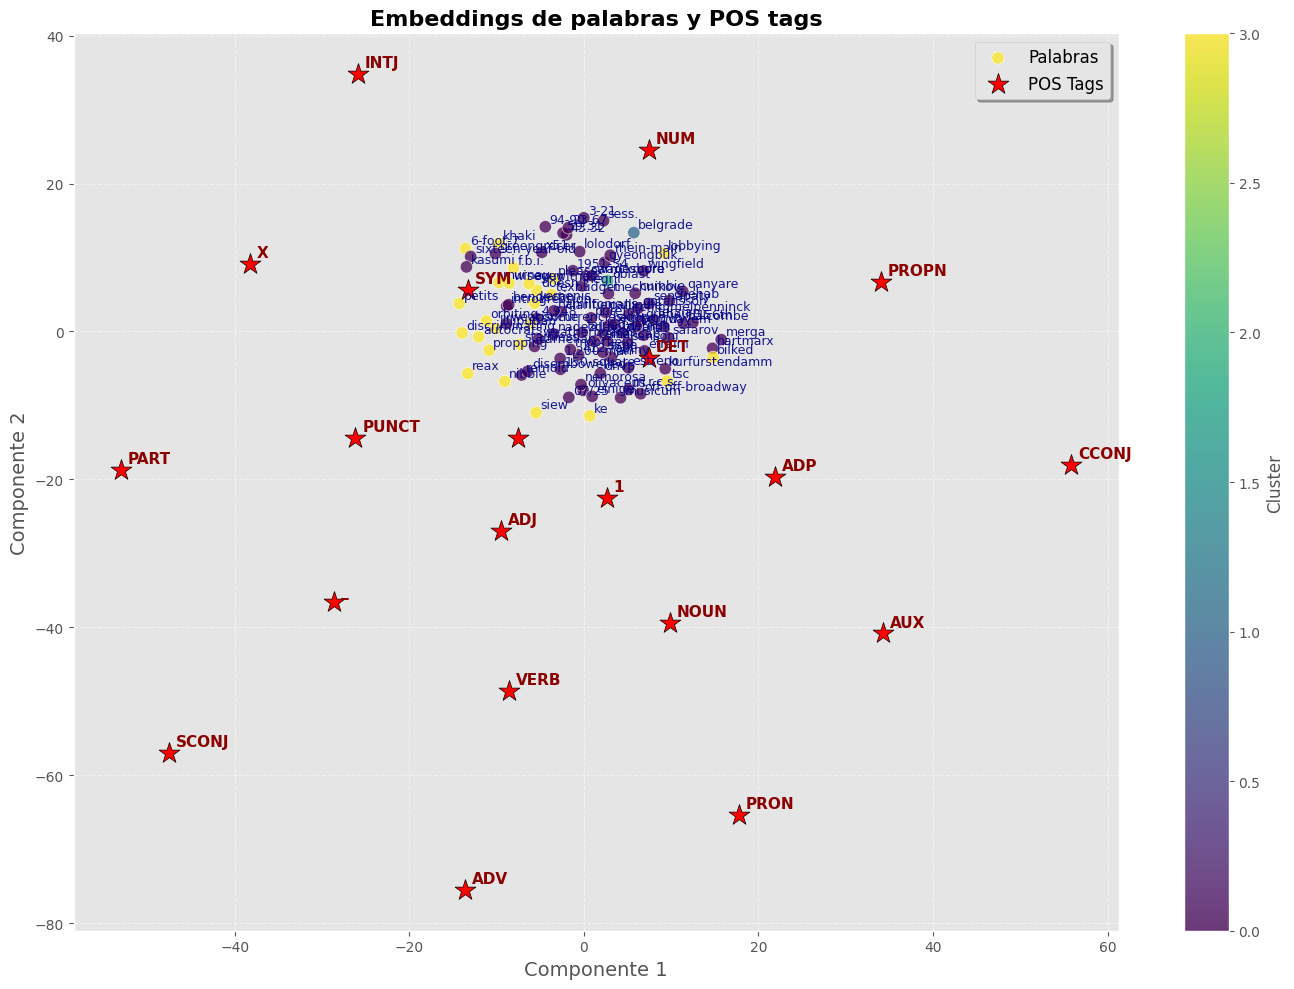

In [ ]:
plt.figure(figsize=(14, 10))

# Scatter de palabras con un alpha para transparencia y borde blanco para mejor visibilidad
scatter = plt.scatter(projected_points[:, 0], projected_points[:, 1],
                      c=etiquetas_cluster, cmap='viridis', alpha=0.75, edgecolor='w', s=80, label='Palabras')

# Scatter de POS tags con estrella roja más visible y borde negro
pos_scatter = plt.scatter(pos_embeddings_2d[:, 0], pos_embeddings_2d[:, 1],
                          marker='*', s=250, c='red', edgecolor='black', label='POS Tags')

# Añadir etiquetas para las palabras
for i, word in enumerate(selected_terms):
    plt.annotate(word, (projected_points[i, 0], projected_points[i, 1]),
                 fontsize=9, alpha=0.9, weight='medium', color='darkblue',
                 xytext=(3,3), textcoords='offset points')

# Añadir etiquetas para POS tags con fuente negrita y un poco más grande
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (pos_embeddings_2d[i, 0], pos_embeddings_2d[i, 1]),
                 fontsize=11, weight='bold', color='darkred',
                 xytext=(5,5), textcoords='offset points')

plt.legend(frameon=True, shadow=True, fontsize=12, loc='best')
plt.xlabel('Componente 1', fontsize=14)
plt.ylabel('Componente 2', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Embeddings de palabras y POS tags", fontsize=16, weight='bold')

plt.tight_layout()
plt.show()


### Conclusión

Los embeddings generados son efectivos en representar tanto la **semántica** como la **sintaxis** de las palabras. El **clustering** revela agrupaciones coherentes, mientras que la comparación con **POS tags** valida que los vectores también contienen señales gramaticales.